In [6]:
#imports
import random
import requests
import wget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import time
from datetime import datetime

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.util import img_as_ubyte

from keras.models import Model, load_model

import tensorflow as tf

In [4]:
# Set some parameters
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 4

# Load locations with latitude and longitude
cities_df = pd.read_csv (r'all_cities.csv')

Tacoma
3/3 [==============================] - 0s 70ms/step


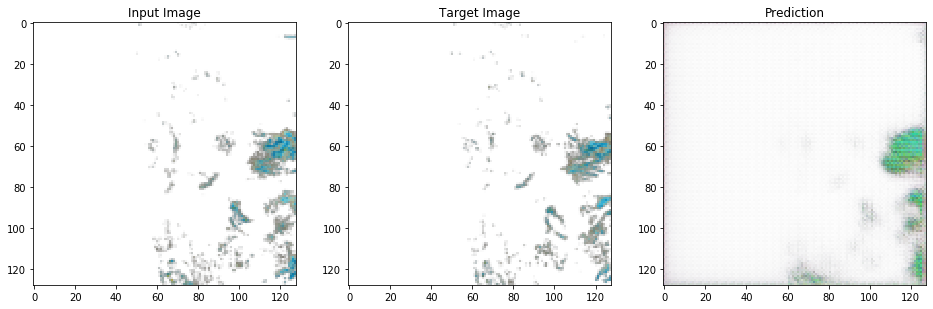

In [7]:
ix = random.randint(0, 528)

# Pull a sequence of new rain radar images for a random city
timestamp = requests.get("https://tilecache.rainviewer.com/api/maps.json")
stamps = str(timestamp.json())
print(cities_df.iloc[ix,1])

stamps = stamps.strip("[")
stamps = stamps.strip("]")
stamps = stamps.split(", ")

# Get latitude and longitude for the location
latitude = str(cities_df.iloc[ix,4])
longitude = str(cities_df.iloc[ix,5])

radar = []
# Check available images / timestamps
for stamp in stamps:
    timestamp = int(stamp)
    dt_object = datetime.fromtimestamp(timestamp)
    checking = dt_object.strftime('%M')
    
    # Download - Full hour
    if checking == '00':
        request = "https://tilecache.rainviewer.com/v2/radar/"+stamp+"/512/4/"+latitude+"/"+longitude+"/2/0_0.png"
        response = requests.get(request)
        
        # Resize, format and store the images
        img = imageio.imread(response.content)
        img = resize(img/255, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        radar.append(img)

# Prepare data in a matrix required for inference
X_test = np.zeros((len(radar), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

i = 0
for img in radar:
    X_test[i] = img_as_ubyte(img)
    i += 1

# Predict 
model = load_model('model-w251weather-1.h5',  custom_objects={'mean_iou': tf.keras.metrics.MeanIoU(num_classes=2)})
preds_test = model.predict(X_test, verbose=1)

# Compare target radar image with prediction
fig, axes = plt.subplots(1, 3, figsize = (16, 5))

#input image
ax = plt.subplot(1,3,1)
ax.set_title('Input Image')
plt.imshow(radar[0]) 

#target output
ax = plt.subplot(1,3,2)
ax.set_title('Target Image')
plt.imshow(radar[1]) 

#predicted output
ax = plt.subplot(1,3,3)
ax.set_title('Prediction')
plt.imshow(preds_test[0]) 